In [29]:
!pip install torchtext==0.11.2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import torch
import torchtext
from torchtext.legacy.data import Field, LabelField
from torchtext.legacy.data import TabularDataset
from torchtext.legacy.data import Iterator, BucketIterator

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# data processing - on local file
#import pandas as pd
#train = pd.read_csv('data/train.csv',delimiter=';')[['text', 'account.type']]
#train.to_csv('data/train.tsv', index = False, header = ['text','label'],sep = '\t')
#val = pd.read_csv('data/validation.csv',delimiter=';')[['text', 'account.type']]
#val.to_csv('data/validation.tsv', index = False, header = ['text','label'],sep = '\t')
#test = pd.read_csv('data/test.csv',delimiter=';')[['text', 'account.type']]
#test.to_csv('data/test.tsv', index = False, header = ['text','label'],sep = '\t')

In [32]:
def whitespace_tokenize(text):
    """
    Tokenizes English words from a string into a list of strings (tokens)
    """
    return text.strip().split()

# define TorchText's Fields with tokenizer
TEXT = Field(sequential=True, tokenize=whitespace_tokenize, lower=True)
LABEL = Field(sequential=False, unk_token = None)

#use TabularDataset class and Fields to process the tsv files (train, dev, and test).
train, val, test = TabularDataset.splits(
    path="/content/drive/MyDrive/585data/", # the root directory where the data lies
    train='train.tsv', validation="validation.tsv", test= "test.tsv",# file names
    format='tsv',
    skip_header=True, # if your tsv file has a header, make sure to pass this to ensure it doesn't get proceesed as data!
    fields=[('text', TEXT), ('label', LABEL)])


# build your vocabulary to map words and labels to integers
TEXT.build_vocab(train, min_freq=2)
LABEL.build_vocab(train)

#print vocab and label size
VOCAB_SIZE = len(TEXT.vocab.stoi)
print('Size of TEXT vocabulary: ', VOCAB_SIZE)

LABEL_SIZE = len(LABEL.vocab.stoi)
print('Size of LABEL vocabulary: ', LABEL_SIZE)

# Prepare the batch Iterators
train_iter, val_iter, test_iter = BucketIterator.splits(
 (train, val, test), # we pass in the datasets we want the iterator to draw data from
 batch_sizes=(32,32,32),
 sort=False,
 sort_key=None,
 shuffle=False,
 sort_within_batch=False,
)

Size of TEXT vocabulary:  16613
Size of LABEL vocabulary:  2


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
def train(loader):
    total_loss = 0.0
    # iterate throught the data loader
    num_sample = 0
    for batch in loader:
        # load the current batch
        batch_input = batch.text
        batch_output = batch.label
        
        batch_input = batch_input.to(device)
        batch_output = batch_output.to(device)
        # forward propagation
        # pass the data through the model
        model_outputs = model(batch_input)
        # compute the loss
        cur_loss = criterion(model_outputs, batch_output)
        total_loss += cur_loss.cpu().item()

        # backward propagation (compute the gradients and update the model)
        # clear the buffer
        optimizer.zero_grad()
        # compute the gradients
        cur_loss.backward()
        # update the weights
        optimizer.step()

        num_sample += batch_output.shape[0]

    return total_loss/num_sample

# evaluation logic based on classification accuracy
def evaluate(loader):
    all_pred=[]
    all_label = []
    with torch.no_grad(): # impacts the autograd engine and deactivate it. reduces memory usage and speeds up computation
        for batch in loader:
             # load the current batch
            batch_input = batch.text
            batch_output = batch.label

            batch_input = batch_input.to(device)
            # forward propagation
            # pass the data through the model
            model_outputs = model(batch_input)
            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
            all_label.extend(batch_output.cpu())
            
    accuracy = accuracy_score(all_label, all_pred)
    f1score = f1_score(all_label, all_pred, average='macro') 
    return accuracy,f1score

def predict(loader):
    all_pred=[]
    with torch.no_grad(): # impacts the autograd engine and deactivate it. reduces memory usage and speeds up computation
        for batch in loader:
             # load the current batch
            batch_input = batch.text

            batch_input = batch_input.to(device)
            # forward propagation
            # pass the data through the model
            model_outputs = model(batch_input)
            # identify the predicted class for each example in the batch
            probabilities, predicted = torch.max(model_outputs.cpu().data, 1)
            # put all the true labels and predictions to two lists
            all_pred.extend(predicted)
      
    return all_pred

In [34]:
class GRUmodel(nn.Module):
  
  def __init__(self, embedding_size = 300, activation = nn.Tanh(), num_layers = 2, hidden_size = 512, output_size = LABEL_SIZE, vocab_size = VOCAB_SIZE):
    # In the constructor we define the layers for our model
    super(GRUmodel, self).__init__()
    # word embedding lookup table
    self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, sparse=False)
    # embedding weight
    self.embedding.weight.data.normal_(0.0,0.05)
    # core ltsm module
    self.gru_rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
    # activation function
    self.activation_fn = activation
    # classification related modules
    self.linear_layer = nn.Linear(hidden_size, output_size) 
    self.softmax_layer = nn.LogSoftmax(dim=1)
    self.debug = False
  
  def forward(self, x):
    # In the forward function we define the forward propagation logic
    if self.debug:
        print("input word indices shape = ", x.size())
    out = self.embedding(x)
    if self.debug:
        print("word embeddings shape = ", out.size())
    out, _ = self.gru_rnn(out) 
    if self.debug:
        print("RNN output (features from last layer of ltsm for all timesteps) shape = ", out.size())
    # classify based on the hidden representation after ltsm processes the last token
    out = out[-1]
    if self.debug:
        print("Tweet embeddings or ltsm output (features from last layer of ltsm for the last timestep only) shape = ", out.size())
    out = self.activation_fn(out)
    if self.debug:
        print("ReLU output shape = ", out.size())
    out = self.linear_layer(out)
    if self.debug:
        print("linear layer output shape = ", out.size())
    out = self.softmax_layer(out) # accepts 2D or more dimensional inputs
    if self.debug:
        print("softmax layer output shape = ", out.size())
    return out

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUmodel()
model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),betas=(0.9, 0.999), lr=0.0003)

MAX_EPOCHS = 25
best_f1 = 0
# start the training
for epoch in range(MAX_EPOCHS):
    # train the model for one pass over the data
    train_loss = train(train_iter)  
    # compute the training accuracy
    train_acc, train_f1= evaluate(train_iter)
    # compute the validation accuracy
    val_acc, val_f1= evaluate(val_iter)
    print('Epoch [{}/{}], Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}, Training F1: {:.4f}, Validation F1: {:.4f}'.format(epoch+1, MAX_EPOCHS, train_loss, train_acc, val_acc, train_f1, val_f1))   
    
    if val_f1 > best_f1:
      best_f1 = val_f1
    # print the loss for every epoch
      model_save = {
              'epoch': epoch,  # number of epoch
              'model_state_dict': model.state_dict(), # model parameters 
              'optimizer_state_dict': optimizer.state_dict(), # save optimizer 
              'loss': train_loss # training loss
              }
      
      # use torch.save to store 
      torch.save(model_save, "/content/drive/MyDrive/Colab Notebooks/ckpt/model_{}.pt".format(epoch))

Epoch [1/25], Loss: 0.0212, Training Accuracy: 0.7324, Validation Accuracy: 0.7011, Training F1: 0.7319, Validation F1: 0.7007
Epoch [2/25], Loss: 0.0142, Training Accuracy: 0.8737, Validation Accuracy: 0.7676, Training F1: 0.8734, Validation F1: 0.7644
Epoch [3/25], Loss: 0.0088, Training Accuracy: 0.9383, Validation Accuracy: 0.7793, Training F1: 0.9383, Validation F1: 0.7786
Epoch [4/25], Loss: 0.0053, Training Accuracy: 0.9629, Validation Accuracy: 0.7732, Training F1: 0.9629, Validation F1: 0.7728
Epoch [5/25], Loss: 0.0033, Training Accuracy: 0.9704, Validation Accuracy: 0.7606, Training F1: 0.9703, Validation F1: 0.7599
Epoch [6/25], Loss: 0.0021, Training Accuracy: 0.9755, Validation Accuracy: 0.7619, Training F1: 0.9755, Validation F1: 0.7605
Epoch [7/25], Loss: 0.0015, Training Accuracy: 0.9870, Validation Accuracy: 0.7537, Training F1: 0.9870, Validation F1: 0.7531
Epoch [8/25], Loss: 0.0011, Training Accuracy: 0.9885, Validation Accuracy: 0.7637, Training F1: 0.9885, Valida

In [36]:
model = GRUmodel()

# load checkpoint 
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/ckpt/model_2.pt") # loading the model obatined after 2nd epoch

# assign the parameters of checkpoint to this new model
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

print(model)

GRUmodel(
  (embedding): Embedding(16613, 300)
  (gru_rnn): GRU(300, 512, num_layers=2)
  (activation_fn): Tanh()
  (linear_layer): Linear(in_features=512, out_features=2, bias=True)
  (softmax_layer): LogSoftmax(dim=1)
)


In [37]:
test_pred = predict(test_iter)
test_pred = [LABEL.vocab.itos[x] for x in test_pred]

In [38]:
import pandas as pd
test_label = pd.read_csv("/content/drive/MyDrive/585data/test.tsv", sep = '\t')
test_y = test_label['label'].to_list()

In [39]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(test_y, test_pred))

              precision    recall  f1-score   support

         bot       0.82      0.74      0.78      1280
       human       0.76      0.84      0.80      1278

    accuracy                           0.79      2558
   macro avg       0.79      0.79      0.79      2558
weighted avg       0.79      0.79      0.79      2558



In [40]:
test_all = pd.read_csv('/content/drive/MyDrive/585data/test.csv',delimiter=';')
test_all['GRU_model'] = test_pred

In [41]:
def plotErrorRatio(X_test_all, prediction_column, min_sample_num=30):
  X_verify = X_test_all[["screen_name", "text", "account.type", prediction_column]]
  X_count_accounts = X_test_all[["screen_name", "account.type"]].groupby("screen_name").count()
  X_verify = X_verify[X_verify["account.type"] != X_verify[prediction_column]]
  X_verify = X_verify.groupby("screen_name").count()["text"].to_frame()
  X_verify["total"] = X_count_accounts["account.type"]
  X_verify.columns = ["errors", "num_samples"]
  X_verify["error_ratio"] = X_verify["errors"] / X_verify["num_samples"]
  X_verify[X_verify["num_samples"] >= min_sample_num]["error_ratio"].plot.bar(figsize=(15,5))
  return X_verify

,errors,num_samples,error_ratio
screen_name,,,
AINarendraModi,7,125,0.056000
DeepDrumpf,7,29,0.241379
DeepElonMusk,2,4,0.500000
GenePark,4,22,0.181818
GenePark_GPT2,12,22,0.545455
Gpt2Wint,2,2,1.000000
JustinTrudeau,4,51,0.078431
Musk_from_Mars,1,2,0.500000
Thorin,1,10,0.100000


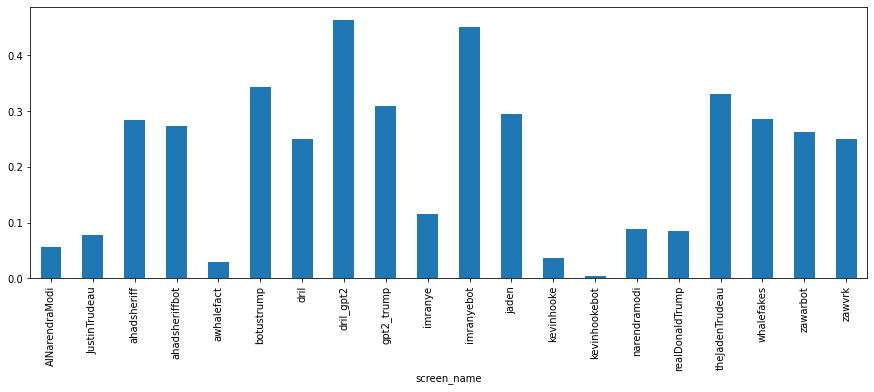

In [42]:
plotErrorRatio(test_all, "GRU_model", min_sample_num=30)